In [2]:
using Plots
using MTH229

# Exercise 1

## Task 1

In [3]:
#function f(x)
f(x) = exp(-x^2)

#create a uniform distribution in the interval [a,b] with N steps
create_uniform_distr(a,b,N) = LinRange(a,b,N)

#do the simple monte carlo integration 1d
function one_dim_uniform_MC(f,a,b,N)
    X = create_uniform_distr(a,b,N)
    return 1/N * sum(f.(X))
end
    

one_dim_uniform_MC (generic function with 1 method)

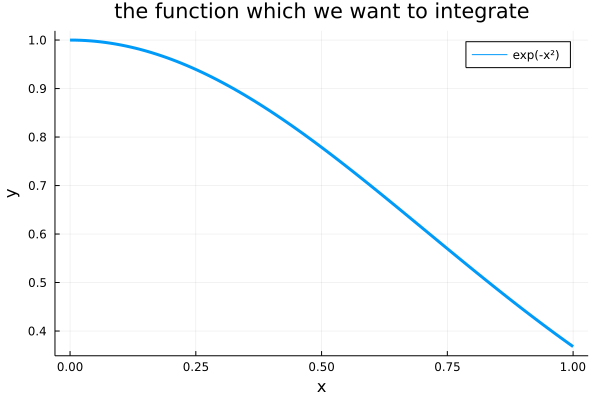

In [4]:
x = LinRange(0,1,100)
plot(x,f.(x), width = 3, label = "exp(-x²)")
plot!(title = "the function which we want to integrate", xlabel = "x", ylabel = "y")

In [5]:
println("the integration should be arround I = $(integrate(f,0,1)) ≈ $(√(π)*erf(1)/2)")
println("with the uniform MC method for N = 10 we find Iₘ = $(one_dim_uniform_MC(f,0,1,10))")
println("the error is $(abs((√(π)*erf(1)/2)-one_dim_uniform_MC(f,0,1,10)))")

the integration should be arround I = sqrt(pi)*erf(1)/2 ≈ 0.746824132812427
with the uniform MC method for N = 10 we find Iₘ = 0.7398541531799746
the error is 0.006969979632452383


```
ich glaube man muss die punkte x von einer random varaible normal verteilung sampeln und nicht einfach eine LinRange generieren!
das werde ich im folgenden versuchen!
```

In [49]:
#simple sampling N points from a uniform distribution in [a,b]
function simple_random_sample(a::Integer,b::Integer,N::Integer)
    x = zeros(N)
    for i in 1:N
        x[i] = rand()*(b-a)+a
    end
    return x
    
end

#do the simple monte carlo integration 1d with random-uniform samples
function one_dim_uniform_MC_random(f,a,b,N)
    X = simple_random_sample(a,b,N)
    return 1/N * sum(f.(X))
end
    

one_dim_uniform_MC_random (generic function with 1 method)

In [50]:
println("the integration should be arround I = $(integrate(f,0,1)) ≈ $(√(π)*erf(1)/2)")
println("with the uniform MC method for N = 10 we find Iₘ = $(one_dim_uniform_MC_random(f,0,1,10))")
println("the error is $(abs((√(π)*erf(1)/2)-one_dim_uniform_MC_random(f,0,1,10)))")

the integration should be arround I = sqrt(pi)*erf(1)/2 ≈ 0.746824132812427
with the uniform MC method for N = 10 we find Iₘ = 0.7424679286927844
the error is 0.06699117502111818


## Task 2

In [6]:
g(x) = e/(e-1)*exp(-x)
G⁽⁻¹⁾(y) = - log(1-(e-1)*y/e)
trick_fkt(y) = f(G⁽⁻¹⁾(y))/g(G⁽⁻¹⁾(y))

trick_fkt (generic function with 1 method)

In [55]:
println("with the importance sampling method for N = 10 we find Iₘ = $(one_dim_uniform_MC_random(trick_fkt,0,1,10))")

with the importance sampling method for N = 10 we find Iₘ = 0.7499014778046256


(suprisingly!?) this result is worse then the one we obtaines in task1 using the simple sampling. Maybe this is because the function f(x) is quite flat and therfore the uniform sampling works best?!

In [ ]:
#Antwort:
#was ich falsch gemacht habe ist dass ich invertiert habe das aber garnicht möglich ist, da die invertierte funktion dan bei y = 1 nicht definiert wäre. 
#deshalb muss man x werte nach g samplen(am besten mit der rejecetion method) und dann damit das integral berechnen!


## Task 3

The goal is to plot the error for different N for both methods(simple sampling and importance sampling) in order to get an Idea about the order of convergence of both methods.

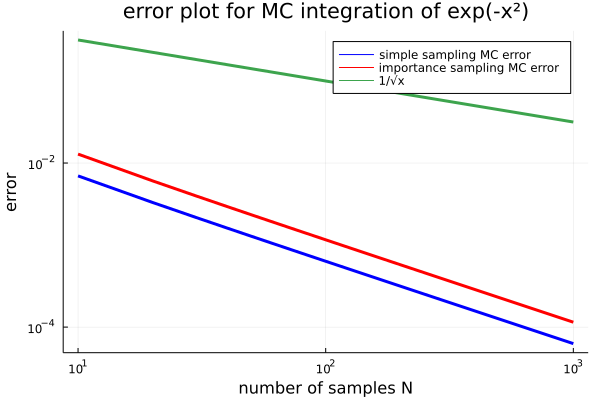

In [58]:
comparison_value = √(π)*erf(1)/2
N = Int.(round.(LinRange(10,1000,100)))

simple_MC = one_dim_uniform_MC.(f,0,1,N)
simple_MC_error = abs.(comparison_value.-simple_MC)

important_MC = one_dim_uniform_MC.(trick_fkt,0,1,N)
important_MC_error = abs.(comparison_value.-important_MC)

plot(N,simple_MC_error, label = "simple sampling MC error", color = "blue", width = 3)
plot!(N,important_MC_error, label = "importance sampling MC error", color = "red", width = 3)
plot!(N,x->1/sqrt(x),label = "1/√x",width = 3)
plot!(title = "error plot for MC integration of exp(-x²)",xlabel = "number of samples N", ylabel = "error", xaxis = :log, yaxis = :log)




this confirmes my assumption from above that indeed the simple sampling has a smaller error then the importance sampling. Which confuses me a bit as i think this can't be the case as importance sampling should be more precise!

What on also can observe in the plot is that the error indeed goes like 1/sqrt(N) as expected.

I think the problem with my solution is that I didn't used a RNG to create the "uniform" distribution. Instead I just used a LinRange which for me is also a uniform distribution?!

# Exercise 2

## Task 1

In [91]:
#1 choose N particles in a box of length L such that they wont overlap 

#calculate distance
distance(a,b) = sqrt((a[1]-b[1])^2+(a[2]-b[2])^2+(a[3]-b[3])^2)

#checks the intersection of one possible new sphere to the others and the boundaries
function rejection_check(spheres, L, R, new)
    
    x = new[1]
    y = new[2]
    z = new[3]
    #checking if the spheres intersects with the boundaries
    if x < R || x > L-R
        return false
    elseif y < R || z > L-R
        return false
    elseif z < R || z > L-R
        return false
    end
    #check if the new sphere intersects the existing spheres
    for i in size(spheres,1)
        if distance(spheres[i,:],new) < 2*R
            return false
        end
    end
    return true
end

#repete until we have found n spheres
function make_spheres(N,R,L)
    
    count = 0 #number of found spheres
    spheres = zeros(N,3)
    while count < N
        new = (rand()*L,rand()*L,rand()*L)
        if rejection_check(spheres,L,R,new)
            count +=1
            spheres[count,:] .= new
        end
    end
    return spheres
end

#calculates the average distance for a given configuration
function average_dist(config)
    N = size(config,1)
    sum = 0
    for i in 1:N-1
        for j in i+1:N
            sum += distance(config[i,:],config[j,:])
        end
    end
    return sum * 2/(N*(N-1))
end    


function big_average(M,L,R,N)
    
    sum = 0
    for i in 1:M
        sum += average_dist(make_spheres(N,R,L))
    end
    return sum/M
end


big_average (generic function with 1 method)

In [92]:
spheres1 = make_spheres(10,0.5,10)

10×3 Matrix{Float64}:
 3.8429   1.58514   0.997861
 8.46944  8.69775   7.03602
 6.82901  0.878638  4.85525
 7.3797   1.71303   5.12922
 3.16013  0.886052  1.91525
 1.91921  0.510125  1.30915
 3.74586  9.40999   6.48566
 8.77027  6.12153   5.75716
 4.07074  3.40002   3.40245
 3.28567  1.51082   0.594864

In [93]:
average_dist(spheres1)


6.0883833164839665

In [94]:
big_average(100,10,0.5,10)

6.053080841229821

## Task 2

┌ Warning: Skipped marker arg o.
└ @ Plots /Users/Paul/.julia/packages/Plots/CBYO0/src/args.jl:1209
┌ Warning: Skipped marker arg o.
└ @ Plots /Users/Paul/.julia/packages/Plots/CBYO0/src/args.jl:1209
┌ Warning: Skipped marker arg o.
└ @ Plots /Users/Paul/.julia/packages/Plots/CBYO0/src/args.jl:1209
┌ Warning: Skipped marker arg o.
└ @ Plots /Users/Paul/.julia/packages/Plots/CBYO0/src/args.jl:1209


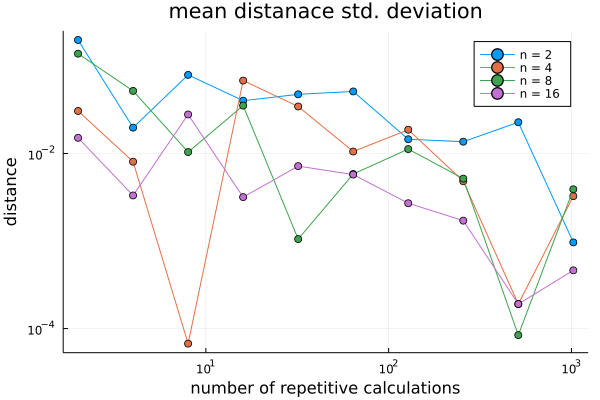

In [126]:
#plot the big average for differnt M 
L = 1
R = 0.01
dim = 3
N = 10

M_values = [2^i for i in 1:10]
n_values = [2, 4, 8, 16]


plot(M_values,abs.(big_average.(M_values,L,R,n_values[1]) .- 0.65),label = "n = $(n_values[1])", marker = "o")
plot!(M_values,abs.(big_average.(M_values,L,R,n_values[2]) .- 0.65),label = "n = $(n_values[2])", marker = "o")
plot!(M_values,abs.(big_average.(M_values,L,R,n_values[3]) .- 0.65),label = "n = $(n_values[3])", marker = "o")
plot!(M_values,abs.(big_average.(M_values,L,R,n_values[4]) .- 0.65),label = "n = $(n_values[4])", marker = "o")
plot!(title = "mean distanace std. deviation",xlabel = "number of repetitive calculations", ylabel = "distance", xaxis = :log, yaxis = :log)